<a href="https://colab.research.google.com/github/Selva987654/NSL-KDD-Dataset-Intrusion-detection-and-network-attack-record/blob/main/NSL_KDD_Dataset_%E2%80%93_Intrusion_detection_and_network_attack_record.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✔ Dataset Loaded Successfully!
   duration  protocol_type   service      flag  src_bytes  dst_bytes  \
0  0.666287       0.577740  0.248644  0.039280   0.151331   0.441503   
1  0.143014       0.729235  0.539983  0.485997   0.055436   0.291892   
2  0.401813       0.101389  0.961499  0.367041   0.133935   0.567280   
3  0.887278       0.168009  0.660708  0.656651   0.614879   0.400250   
4  0.360109       0.274258  0.064115  0.353499   0.531030   0.539846   

       land  wrong_fragment    urgent       hot  ...  dst_host_srv_count  \
0  0.996257        0.739421  0.042406  0.244036  ...            0.223672   
1  0.143944        0.858332  0.304242  0.901082  ...            0.610218   
2  0.080431        0.875795  0.603445  0.235740  ...            0.077247   
3  0.853977        0.907267  0.469452  0.998242  ...            0.054651   
4  0.001381        0.897988  0.350272  0.597418  ...            0.118315   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                0.336817 

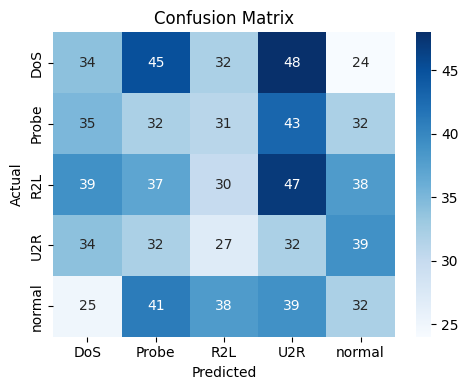

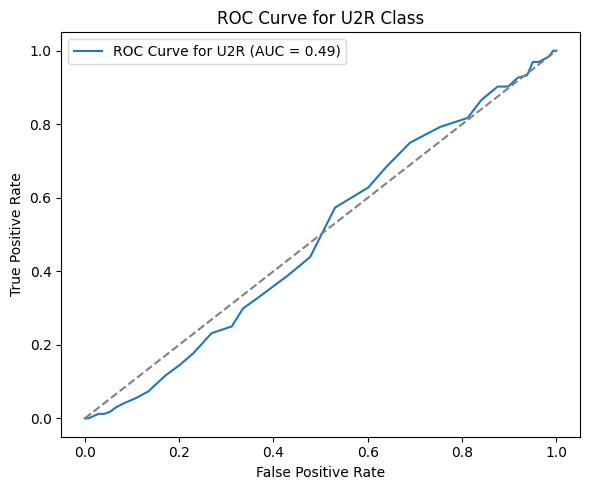

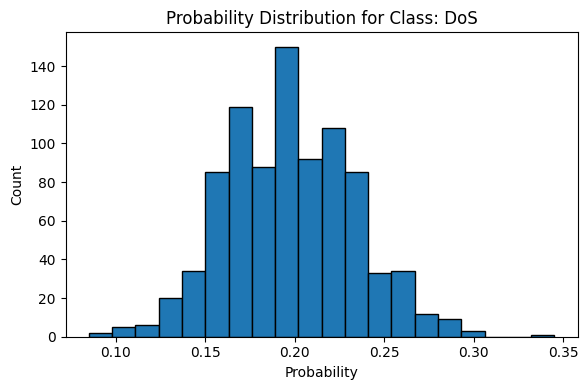


=== SAMPLE PREDICTION ===
Predicted Label : U2R
Probabilities per class: [0.095 0.085 0.12  0.61  0.09 ]
Classes: ['DoS' 'Probe' 'R2L' 'U2R' 'normal']


In [3]:
#  NSL-KDD INTRUSION DETECTION PROJECT (FULL PIPELINE)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, roc_curve, auc
)
df = pd.read_csv("/content/drive/MyDrive/nsl_kdd_dataset.csv")

print("✔ Dataset Loaded Successfully!")
print(df.head())

LABEL_COLUMN = "label"

X = df.drop(LABEL_COLUMN, axis=1)
y = df[LABEL_COLUMN]

numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print("\nNumeric Columns:", list(numeric_cols))
print("Categorical Columns:", list(categorical_cols))

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model.fit(X_train, y_train)
print("\n✔ Model Training Completed!")

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

print("\n============= MODEL PERFORMANCE ============")
print("Accuracy  :", accuracy_score(y_test, y_pred))
print("Precision :", precision_score(y_test, y_pred, average='weighted'))
print("Recall    :", recall_score(y_test, y_pred, average='weighted'))
print("ROC-AUC   :", roc_auc_score(y_test, y_prob, multi_class='ovr'))
print("==============================================\n")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

if 'U2R' in model.classes_:
    u2r_class_idx = list(model.classes_).index('U2R')
    fpr, tpr, thresholds = roc_curve(y_test == 'U2R', y_prob[:, u2r_class_idx])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC Curve for U2R (AUC = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for U2R Class")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Cannot plot ROC curve for 'U2R' as it's not in the classes.")

plt.figure(figsize=(6,4))
plt.hist(y_prob[:, 0], bins=20, edgecolor="black")
plt.title("Probability Distribution for Class: " + str(model.classes_[0]))
plt.xlabel("Probability")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


sample = pd.DataFrame([X.iloc[0].to_dict()])

sample['duration'] = 2.5


pred = model.predict(sample)[0]
prob = model.predict_proba(sample)[0]

print("\n=== SAMPLE PREDICTION ===")
print("Predicted Label :", pred)
print("Probabilities per class:", prob)
print("Classes:", model.classes_)
